In [1]:
import pandas as pd
from spacytextblob.spacytextblob import SpacyTextBlob
import requests
import praw
import datetime
import sktime
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import TrendForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from alpha_vantage.timeseries import TimeSeries
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.utils.plotting import plot_series


from alpha_vantage.cryptocurrencies import CryptoCurrencies
import matplotlib.pyplot as plt
from sktime.datatypes._panel._convert import (
    from_2d_array_to_nested,
    from_nested_to_2d_array
)
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import median_absolute_error
import warnings

## Pull in Eth Ticker data  from Alpha Vantage's CrytpoCurrency API.

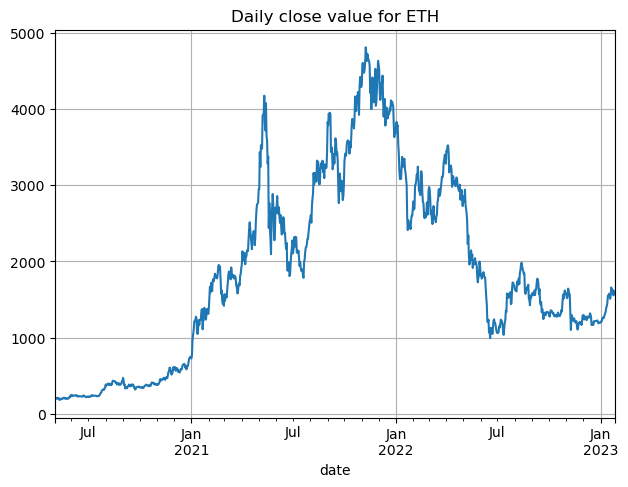

In [2]:
def get_ticker_data(key):
    #Used for exploring data format structure and metadata
    #ts = TimeSeries(key, output_format ='pandas')
    #data, meta = ts.get_intraday(function=DIGITAL_CURRENCY_DAILY, 'ETH', interval='1min', outputsize='full')
    
    cc = CryptoCurrencies(key=key, output_format='pandas')
    data, meta_data = cc.get_digital_currency_daily(symbol='ETH', market='USD')
    data['4b. close (USD)'].plot()
    plt.tight_layout()
    plt.title('Daily close value for ETH')
    plt.grid()
    plt.show()
    return data, meta_data
key = "Insert Key Here"

    
data, meta = get_ticker_data(key)


## Check for Stationarity

In [ ]:
#FIXME: TODO
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, squeeze=True)
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

## Check data is in a Pandas dataframe and is monotonically increasing by DateTime Index.

In [3]:
type(data)

pandas.core.frame.DataFrame

In [4]:
y=data['4b. close (USD)'][::-1]
y_exp = y[0:len(y)]


In [5]:
sktime.datatypes.check_raise(y, mtype='pd.Series')

True

## Fitting and Predicting

Using autoARIMA to determine best P, D, and Q parameters, fit the model to previous data and predict the next day's value.

In [6]:
warnings.filterwarnings('ignore')

y_train, y_test = temporal_train_test_split(y, test_size = .001)
y_train.index = pd.DatetimeIndex(y_train.index, freq="D")
test_indices = y_test.index
#print(test_indices)

fh = ForecastingHorizon(test_indices, is_relative=False)
forecaster = AutoARIMA(start_p=0, max_p=3, seasonal= False)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)


print(mean_absolute_percentage_error(y_test, y_pred))
y_resid = y_pred - y_test
#fig,ax = plot_series(y_resid)
#fig1, ax1 = plot_series(y_pred, y_test, labels= ["Pred", "Actual"])
print('Prediction: ' + str(y_pred) + '\n', 'Actual: ' + str(y_test) + '\n')
print('Residual: ' + str(y_resid) + '\n')


0.012965121920217598
Prediction: 2023-01-27    1602.0246
dtype: float64
 Actual: date
2023-01-27    1581.52
Name: 4b. close (USD), dtype: float64

Residual: 2023-01-27    20.5046
dtype: float64



## Evaluation of Model
Predict the next day's closing price for the last 30 days and compare to actual prices.

In [8]:
warnings.filterwarnings('ignore')
df_preds = pd.DataFrame()
df_resids = pd.DataFrame()
#dict_preds = {}
#dict_resids = {}
for i in range (30):
    y_train, y_test = temporal_train_test_split(y_exp[0:-i or None], test_size = .001)
    y_train.index = pd.DatetimeIndex(y_train.index, freq="D")
    test_indices = y_test.index
    fh = ForecastingHorizon(test_indices, is_relative=False)
    order_param = [1, 0, 2] #p, q, d
    forecaster1 = AutoARIMA(start_p=0, max_p=3, seasonal= False)
    forecaster1.fit(y_train)
    y_pred = forecaster.predict(fh)
    y_resid = y_pred - y_test
    df_preds = pd.concat([df_preds, y_pred], axis="rows")
    df_resids = pd.concat([df_resids, y_resid], axis="rows")


## Plot for comparing actual to predicted values and the residuals of those days.

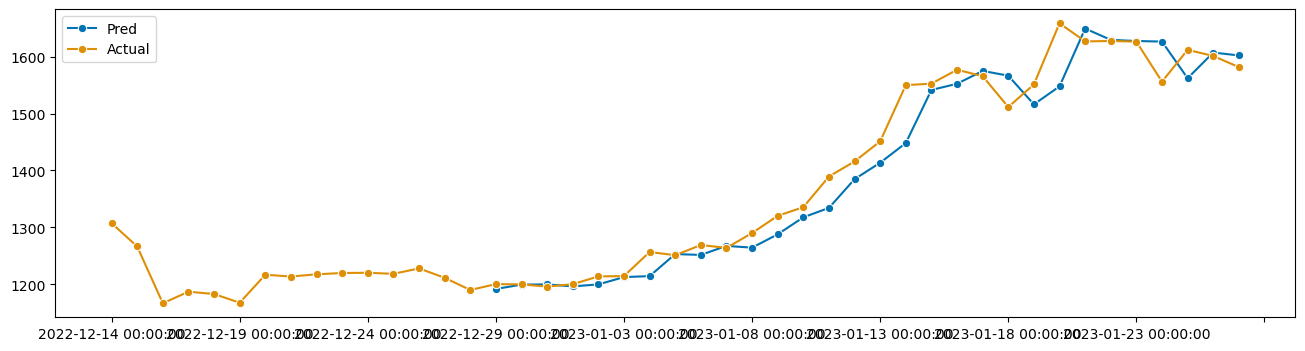

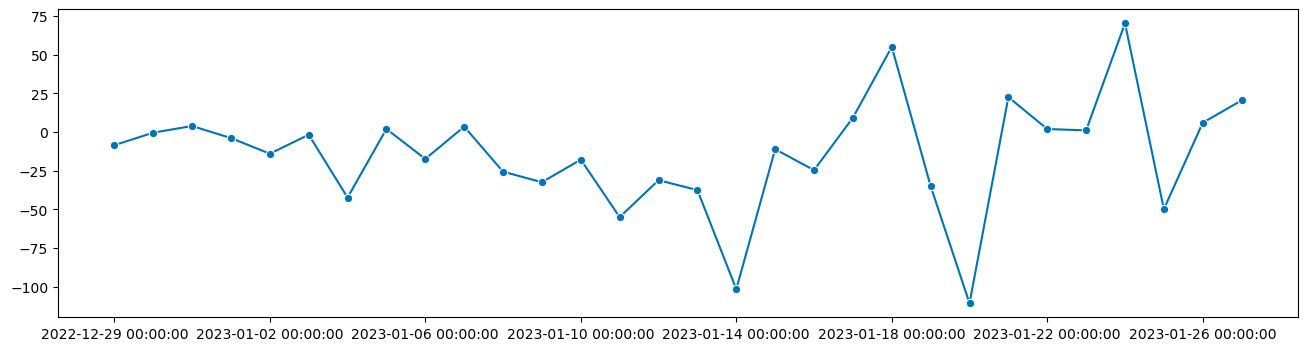

In [9]:
df_preds = df_preds.iloc[::-1]
df_resids = df_resids.iloc[::-1]
fig1, ax1 = plot_series(df_preds, y_exp[-45:], labels= ["Pred", "Actual"])
fig,ax = plot_series(df_resids)

## Predicting Tomorrow's Price

In [10]:
test_index = len(y)
today = y[-1:].index
print(today)
tom= today + datetime.timedelta(days = 1)
print(tom)

DatetimeIndex(['2023-01-27'], dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2023-01-28'], dtype='datetime64[ns]', name='date', freq=None)


In [11]:
fh = ForecastingHorizon(tom, is_relative=False)
day_predict = forecaster.predict(fh)

In [12]:
print(y[-1:])
print(day_predict)

date
2023-01-27    1581.52
Name: 4b. close (USD), dtype: float64
2023-01-28    1601.944095
dtype: float64


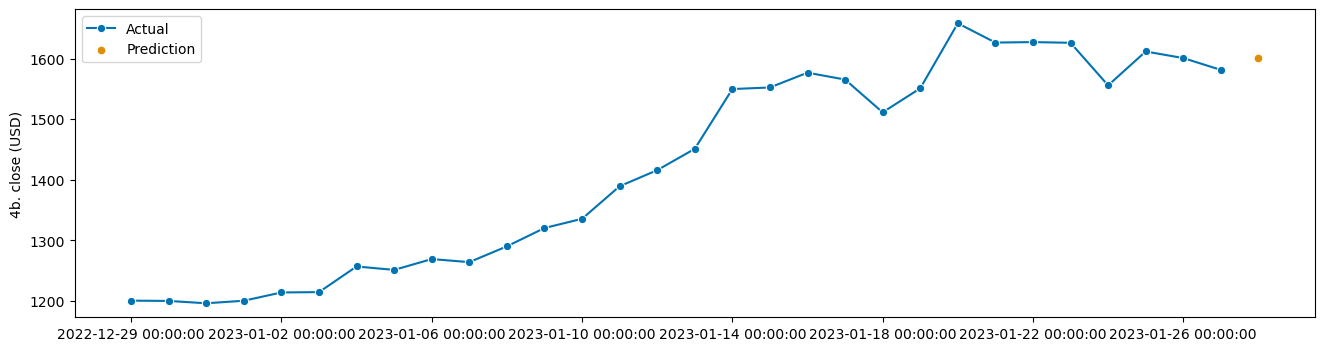

In [13]:
fig2, ax2 = plot_series(y[-30:], day_predict, labels= ["Actual", "Prediction"])